# **Physics-Informed Super-Resolution:**

This notebook seeks to provide a pedagogical overview of the research conducted in the recent paper: "Physics-Informed CNNs for Super Resolution of Sparse Observations on Dynamical Systems" [[1]](#References:) - **available on [arXiV](https://arxiv.org/pdf/2210.17319v2.pdf)**. 

**Abstract:**

>In the absence of high-resolution samples, super-resolution of sparse observations on dynamical systems is a challenging problem with wide-reaching applications in experimental settings. We showcase the application of physics-informed convolutional neural networks for super-resolution of sparse observations on grids. Results are shown for the chaotic-turbulent Kolmogorov flow, demonstrating the potential of this method for resolving finer scales of turbulence when compared with classic interpolation methods, and thus effectively reconstructing missing physics.

The following diagram provides an overview of the approach, demonstrating that we wish to use a machine learning model to recover high-resolution samples from low-resolution inputs.

<div>
    <center>
        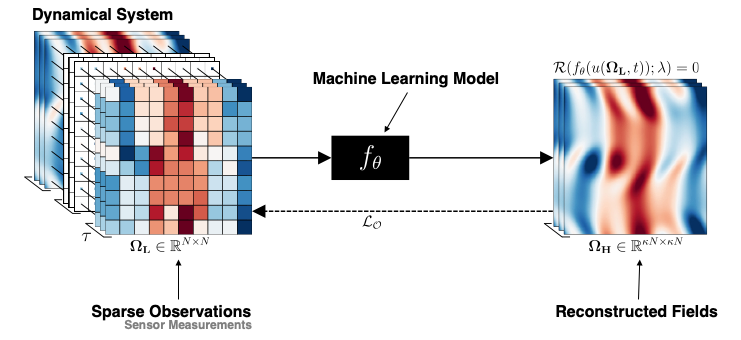
    </center>
</div>

The notebook is structured as follows:

1. [Imports and Parameter Definitions](#Imports-and-Parameters:)
2. [Loading the Data](#00-::-Loading-the-Data:)
3. [Helper Functions](#01-::-Helper-Functions:)
4. [Time Distributed Layers](#02-::-TimeDistributed-Layers:)
5. [Defining the Model](#03-::-Defining-the-Model:)
6. [Defining the Loss](#04-::-Defining-the-Loss:)
7. [Defining the Training Loop](#05-::-Defining-the-Training-Loop:)
8. [Training the Model](#06-::-Training-the-Model:)
9. [Postprocessing](#07-::-Postprocessing:)
10. [Homework](#08-::-Homework:)

## **Imports and Parameters:**
This section is responsible for loading the relevant packages as well as setting certain constants that will be used throughout. Data from a simulation of the Kolmogorov flow is loaded and will be used for the super-resolution task throughout.

**Imports:**
<br> First we need to import the relative packages. We will be writing most of the functionality ourselves but will rely on `torch` for the machine learning framework and `kolsol` to provide the ability to simulate the dynamical system.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import enum
import functools as ft
from pathlib import Path
from typing import Any, NamedTuple, Optional, Type, TypeVar

import einops
import ml_collections
import numpy as np
import opt_einsum as oe
import torch
import torch.nn as nn

from kolsol.torch.solver import KolSol
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from mpl_toolkits.axes_grid1 import make_axes_locatable

T = TypeVar('T', np.ndarray, torch.Tensor)

**Device Setup:**
<br> We want to work on GPU if there is one available. By setting `torch.backends.cudnn.benchmark` to `True` we can optimise the tensor operations.

In [2]:
CUDNN_BENCHMARKS = True
torch.backends.cudnn.benchmark = CUDNN_BENCHMARKS

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE_KWARGS = {'num_workers': 1, 'pin_memory': True} if DEVICE == 'cuda' else {}

**Simulation Constants:**
<br> These constants determine how the dynamical system is simulated.

In [3]:
NK = 30                 # number of symmetric wavenumbers in the Fourier discretisation
RE = 42.0               # reynolds number of the flow
DT = 5e-3               # time step used for the data generation
NF = 4                  # forcing frequency of the Kolmogorov flow

**Training Constants:**
<br> These constants determine the super resolution task and how we train our model.

In [4]:
LR_NX = 10              # spatial resolution of the low-resolution observations
SR_FACTOR = 7           # factor by which we wish to super resolve

N_EPOCHS = 5            # number of epochs to train for
BATCH_SIZE = 128        # number of items to process per batch
LEARNING_RATE = 3e-4    # learning rate for the optimisation process
L2 = 0.0                # L2 regularisation of the weights during training

LAMBDA_WEIGHT = 1e-6    # weighting term for the residual loss

**Path Definitions:**
<br> To save time we provide the training/validation data as well as pre-trained model weights.

In [5]:
BASE_PATH = Path.cwd() / 'data'

TRAINING_DATA = BASE_PATH / 'train.pt'
VALIDATION_DATA = BASE_PATH / 'validation.pt'

MODEL_PATH = BASE_PATH / 'model.pt'

## **00 :: Loading the Data:**
We load the relevant data from file and visualise a few random time-steps to get a better idea of the data that we are working with.

In [6]:
train_u = torch.load(TRAINING_DATA)
validation_u = torch.load(VALIDATION_DATA)

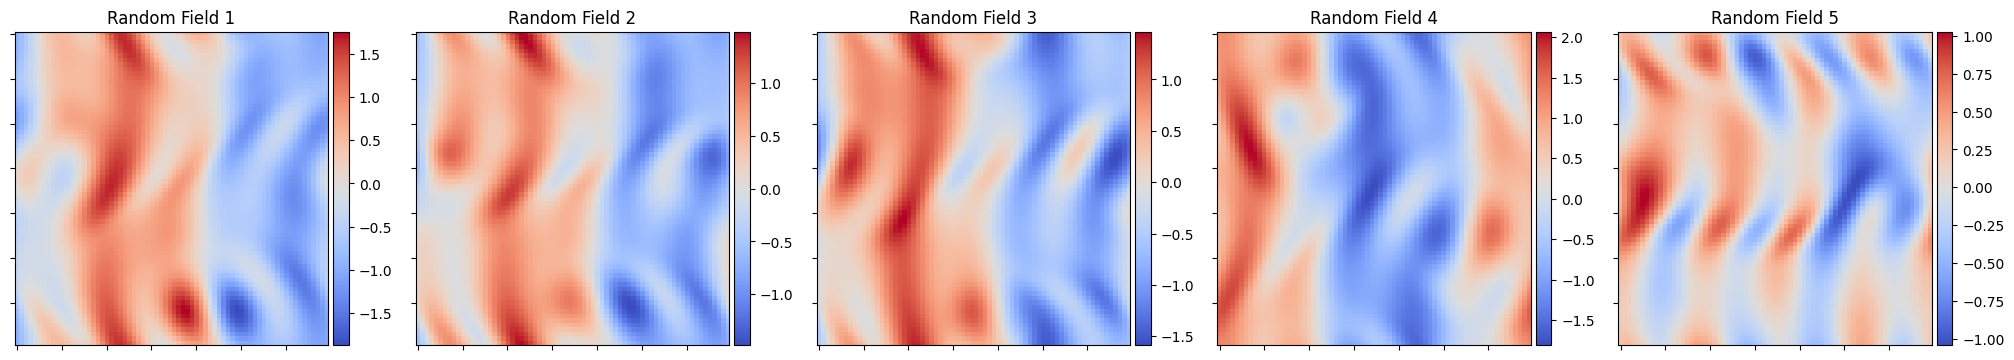

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
axs = axs.flatten()

# choose five random fields
random_idx = np.random.choice(np.arange(train_u.shape[0]), size=5, replace=False)

for i, (idx, ax) in enumerate(zip(random_idx, axs)):
    
    # plot the u-component of velocity
    im = axs[i].imshow(train_u[idx, 0, 0, ...], cmap='coolwarm')
    
    # turn off tick labels
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax)
    
    ax.set_title(f'Random Field {i + 1}')

## **01 :: Helper Functions:**

This section is responsible for providing helper functions which will be useful later on. Namely

1. `get_low_res_grid()` -- responsible for obtaining the sensor observations from the high-resolution data.
2. `generate_dataloader()` -- produces a generator which will continuously load the next samples required for training the network.

Finally, we produce two dataloaders: `train_loader, validation_loader` -- these will be used in the training process further down.

**`get_low_res_grid()`** -- function to obtain measurements at sensor locations from high-resolution data.
<br> The diagram below provides a basic depiction of what the function achieves. This will be used to generate the low-resolution data as well as to help compute the loss.

<div>
    <center>
        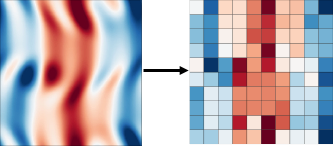
    </center>
</div>

In [8]:
def get_low_res_grid(high_res: T, factor: int = 7) -> T:

    """Produces low-resolution grid from high-resolution grid.
    
    Note: This will only work with two-dimensional fields.
          Input shape must be (..., N, N).
    
    Parameters:
    -----------
    high_res: np.ndarray | torch.Tensor
        High-resolution field to generate low-resolution field from.
    factor: int
        Odd factor by which to downsample the high-resolution field.

    Returns:
    ---------
    low_res: np.ndarray | torch.Tensor
        Low-resolution field sampled from high-resolution field.
    """

    if factor % 2 == 0:
        raise ValueError('Must provide an odd factor to allow overlapping sensor measurements.')

    n_high_res = high_res.shape[-1]
    target_res = int(n_high_res / factor)

    if not n_high_res % target_res == 0:
        raise ValueError('High resolution data and factor do not produce valid low resolution field.')

    start_idx = int((factor - 1) / 2)

    lr_slice = slice(start_idx, n_high_res, factor)
    low_res = high_res[..., lr_slice, lr_slice]

    if not low_res.shape[-1] == target_res:
        raise ValueError('Unable to produce low resolution field.')

    return low_res

In [9]:
lo_res_example = get_low_res_grid(train_u, factor=SR_FACTOR)
lo_res_example.shape

torch.Size([2048, 2, 2, 10, 10])

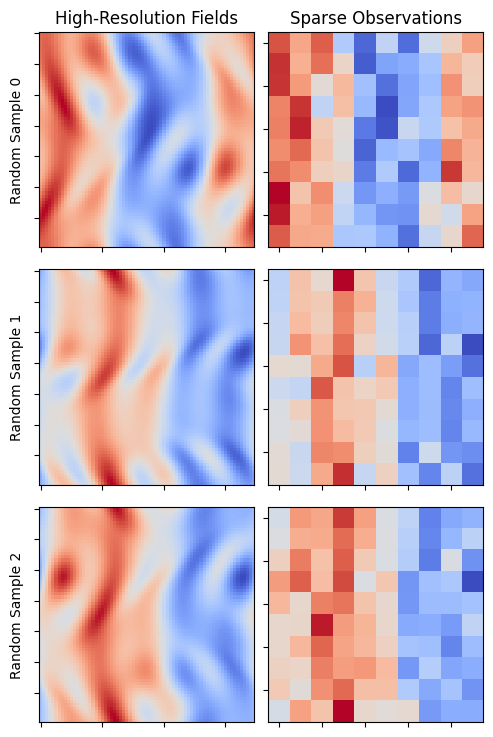

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(5, 7.5))
axs = axs.flatten()

random_idx = np.random.choice(np.arange(train_u.shape[0]), size=3, replace=False)

for i, idx in enumerate(random_idx):
    axs[i * 2 + 0].imshow(train_u[idx, 0, 0, ...], cmap='coolwarm')
    axs[i * 2 + 1].imshow(lo_res_example[idx, 0, 0, ...], cmap='coolwarm')
    
    axs[i * 2 + 0].set_ylabel(f'Random Sample {i}')
    
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
axs[0].set_title('High-Resolution Fields')
axs[1].set_title('Sparse Observations')
    
fig.tight_layout()

In [11]:
class UnlabeledTensorDataset(TensorDataset):
    
    def __init__(self, data_tensor: torch.Tensor) -> None:
        
        """Dataset for unlabeled tensors.
    
        Parameters
        ----------
        data_tensor: torch.Tensor
            Tensor to form dataset with.
        """

        super().__init__()
        self.data_tensor = data_tensor
   
    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data_tensor[idx]
  
    def __len__(self) -> int:
        return len(self.data_tensor)

In [12]:
def generate_dataloader(data: torch.Tensor, dataloader_kwargs: dict[str, Any], device_kwargs: dict[str, Any]) -> DataLoader:
    
    """Generate DataLoader from given data.
    
    Parameters:
    -----------
    data: torch.Tensor
        Data to generate DataLoader from.
    dataloader_kwargs: dict[str, Any]
        Key word arguments for the DataLoader.
    device_kwargs: dict[str, Any]
        Key word arguments for the device.
        
    Returns:
    --------
    dataloader: DataLoader
        Iterable dataloader for the given data.
    """
    
    dataset = UnlabeledTensorDataset(data)
    dataloader = DataLoader(dataset, **dataloader_kwargs, **device_kwargs)
    
    return dataloader

In [13]:
dataloader_kwargs = dict(batch_size=BATCH_SIZE, shuffle=True, drop_last=CUDNN_BENCHMARKS)

train_loader = generate_dataloader(train_u, dataloader_kwargs, DEVICE_KWARGS)
validation_loader = generate_dataloader(validation_u, dataloader_kwargs, DEVICE_KWARGS)

In [14]:
for hi_res in train_loader:
    example_sample = hi_res
    break

example_sample.shape

torch.Size([128, 2, 2, 70, 70])

## **02 :: TimeDistributed Layers:**

The network that we will produce does not see any temporal component of the observations on the dynamical system; as such we need to identify a way in which to compute the residual. We consider that each sample to the network consists of a window of $\tau$ sequential time-steps. While a convolutional neural network typically takes inputs of shape `(batch, channel, x, y)`, we want to augment this to include an additional time dimension: `(batch, time, channel, x, y)`.

In order to avoid increasing the computational complexity, we want to make sure to use weight sharing. In the `TimeDistributed` layers defined below, the same weights of the network are used for each item in the `time` dimension, much like you would expect from the `batch` dimension.

In [15]:
class TimeDistributed(nn.Module):

    def __init__(self, module: nn.Module) -> None:

        """TimeDistributed Layer.
        
            Allows arbitrary layer operation to be applied over the second dimension.

            For example, apply a layer operation to a Tensor with:
                t.shape -> (batch_dim=1000, time_dim=2, ...)

            The TimeDistributed layer treats the second dimension as another batch.
        
        Parameters
        ----------
        module: nn.Module
            Module operation to apply over the time-dimension.
        """

        super().__init__()
        self.module = module

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        """Conduct a single forward-pass through the wrapped layer.
        
        Takes inputs of shape: [batch, tau, velocity_channels, x, y]
        
        Parameters
        ----------
        x: torch.Tensor
            Input Tensor.

        Returns
        -------
        y: torch.Tensor
            Output Tensor.
        """

        if not len(x.shape) > 2:
            raise DimensionError(msg='Input must have more than two dimensions.')

        t, n = x.shape[0], x.shape[1]

        x_reshape = x.contiguous().view(t * n, *x.shape[2:])
        y_reshape = self.module(x_reshape)

        y = y_reshape.contiguous().view(t, n, *y_reshape.shape[1:])

        return y


class TimeDistributedWrapper:

    def __init__(self, module: Type[nn.Module]) -> None:

        """Wrapper to generate TimeDistributed layers.
        
        Parameters
        ----------
        module: Type[nn.Module]
            Module to make TimeDistributed.
        """

        self.module = module

    def __repr__(self) -> str:
        return f'TimeDistributed({self.module})'

    def __call__(self, *args: Any, **kwargs: Any) -> nn.Module:
        return TimeDistributed(self.module(*args, **kwargs))

We know that the Kolmogorov flow has periodic boundary conditions - this is information that we can embed in our network. The `PeriodicUpsampler` is responsible for ensuring that upsampling/interpolation 'wraps around' the domain, ensuring that the output is spatially periodic. This is achieved by first padding the input appropriately, conducting the upsampling, and then selecting the relevant domain.

In [16]:
class PeriodicUpsampler(nn.Module):

    def __init__(self, mode: str, scale_factor: int, npad: int = 10) -> None:

        super().__init__()

        self.mode = mode
        self.scale_factor = scale_factor
        self.npad = npad

        self.fn_pad = ft.partial(nn.functional.pad, mode='circular', pad=tuple(self.npad for _ in range(4)))
        self.upsampler = nn.Upsample(scale_factor=self.scale_factor, mode=self.mode)

        upsampled_pad = self.scale_factor * self.npad
        self.slice = slice(upsampled_pad, -upsampled_pad)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.fn_pad(x)
        x = self.upsampler(x)

        x = x[..., self.slice, self.slice]

        return x

In [17]:
# defining TimeDistributed layers
TimeDistributedConv2d = TimeDistributedWrapper(nn.Conv2d)
TimeDistributedConvTranspose2d = TimeDistributedWrapper(nn.ConvTranspose2d)
TimeDistributedPeriodicUpsample = TimeDistributedWrapper(PeriodicUpsampler)
TimeDistributedUpsample = TimeDistributedWrapper(nn.Upsample)

## **03 :: Defining the Model:**

In this section we will define the model responsible for the super-resolution. The model consists of three convolutional layers with intermediate, non-linear activations:

<div>
    <center>
        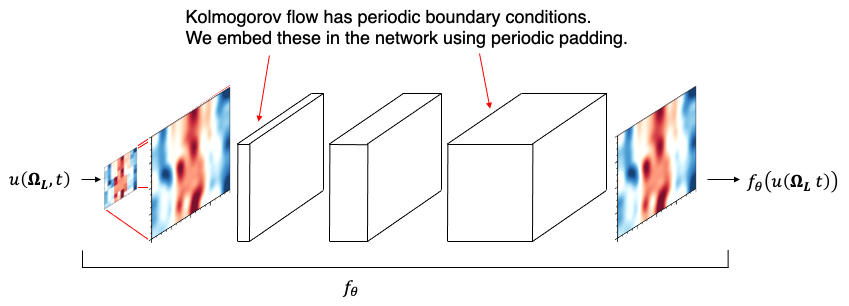
    </center>
</div>

Again, because we have prioir knowledge about the boundary conditions, we can embed this in the convolutional layers by using periodic padding. We will define the class `SRCNN` which is responsible for computing the forward pass through the network - the backward pass and parameter updates will be handled by `PyTorch`.

In [18]:
class SRCNN(nn.Module):

    def __init__(self, lr_nx: int, upscaling: int = 7, mode: str = 'bicubic') -> None:

        """SRCNN: Standard CNN for Super-Resolution.
        
        Parameters:
        -----------
        lr_nx: int
            Low-resolution grid-points.
        upscaling: int
            Upsampling factor for the network.
        mode: str
            Mode of upsampling for the first layer of the network.
        """

        super().__init__()

        if upscaling % 2 == 0:
            raise ValueError('Must provide an odd upscaling value...')

        if mode not in ['bilinear', 'bicubic']:
            raise ValueError('Choose relevant mode for upsampling...')

        self.upscaling = upscaling
        self.mode = mode

        self.lr_nx = lr_nx

        self._conv_kwargs = dict(padding='same', padding_mode='circular')

        # we use a `ReLU` nonlinear activation at each stage of the network
        self.activation = nn.ReLU(inplace=True)

        # our first layer is an upsampling layer -- used to achieve the relevant spatial dimensions
        self.upsample = TimeDistributedPeriodicUpsample(mode=self.mode, scale_factor=self.upscaling, npad=self.lr_nx // 2)

        # we then have three successive convolutional layers - each using a kernel with large spatial extent
        self.conv1 = TimeDistributedConv2d(2, 64, kernel_size=(9, 9), **self._conv_kwargs)
        self.conv2 = TimeDistributedConv2d(64, 32, kernel_size=(5, 5), **self._conv_kwargs)
        self.conv3 = TimeDistributedConv2d(32, 2, kernel_size=(5, 5), **self._conv_kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        """Forward pass through the model.
        
        Parameters:
        -----------
        x: torch.Tensor
            Tensor to pass through the model.
        
        Returns:
        --------
        torch.Tensor
            Output of the model.
        """

        x = self.upsample(x)

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = self.conv3(x)

        return x

In [19]:
model = SRCNN(lr_nx=LR_NX, upscaling=SR_FACTOR)

# move to gpu
model.to(DEVICE)

SRCNN(
  (activation): ReLU(inplace=True)
  (upsample): TimeDistributed(
    (module): PeriodicUpsampler(
      (upsampler): Upsample(scale_factor=7.0, mode=bicubic)
    )
  )
  (conv1): TimeDistributed(
    (module): Conv2d(2, 64, kernel_size=(9, 9), stride=(1, 1), padding=same, padding_mode=circular)
  )
  (conv2): TimeDistributed(
    (module): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=circular)
  )
  (conv3): TimeDistributed(
    (module): Conv2d(32, 2, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=circular)
  )
)

**Lets see the untrained model in action:**

In [20]:
# get sensor observations and move to gpu
sensor_observations = get_low_res_grid(validation_u)
sensor_observations = sensor_observations.to(DEVICE)

# pass sensor observations to the model
hi_res_predictions = model(sensor_observations)

# move back to cpu
sensor_observations = sensor_observations.detach().cpu()
hi_res_predictions = hi_res_predictions.detach().cpu()

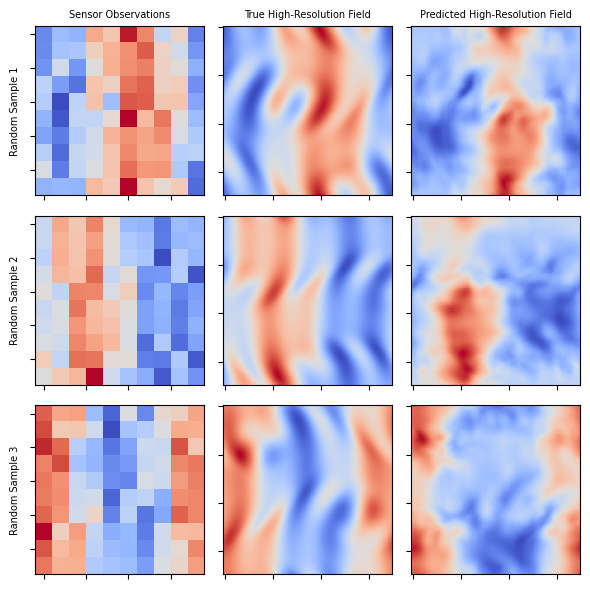

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
axs = axs.flatten()

cmap = 'coolwarm'
fs = 7
random_idx = np.random.choice(np.arange(sensor_observations.shape[0]), size=3, replace=False)

for i, idx in enumerate(random_idx):
    axs[i * 3 + 0].imshow(sensor_observations[idx, 0, 0, ...], cmap=cmap)
    axs[i * 3 + 1].imshow(validation_u[idx, 0, 0, ...], cmap=cmap)
    axs[i * 3 + 2].imshow(hi_res_predictions[idx, 0, 0, ...], cmap=cmap)
    
    axs[i * 3 + 0].set_ylabel(f'Random Sample {i + 1}', fontsize=fs)
    
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
axs[0].set_title('Sensor Observations', fontsize=fs)
axs[1].set_title('True High-Resolution Field', fontsize=fs)
axs[2].set_title('Predicted High-Resolution Field', fontsize=fs)
    
fig.tight_layout()

In [22]:
# do not clutter gpu
del sensor_observations
del hi_res_predictions

## **04 :: Defining the Loss:**

In order to train our model, we attempt to solve an optimisation problem of the form:

$$
\begin{equation}
\begin{aligned}
\theta^* &= \text{argmin}_\theta \mathcal{L}_T \\
\mathcal{L}_T &= \mathcal{L}_{\mathcal{O}} + \alpha \mathcal{L}_{\mathcal{R}}
\end{aligned}
\end{equation}
$$

This loss $\mathcal{L}_T$ is composed of two independent losses, $\mathcal{L}_{\mathcal{O}}, \mathcal{L}_{\mathcal{R}}$. Here we will expand on what each one is responsible for before moving on to define the residual loss.

### **Observation Based Loss - $\mathcal{L}_{\mathcal{O}}$**
The observation based loss $\mathcal{L}_{\mathcal{O}}$ is responsible for minimising the error between the sensor observations and network predictions at those locations. We assume that the data provided by the low-resolution sensor observations is a source of absolute truth, and penalise the network if it is unable to reproduce these data points. The diagram below provides a pictoral representation of the loss:

<div>
    <center>
        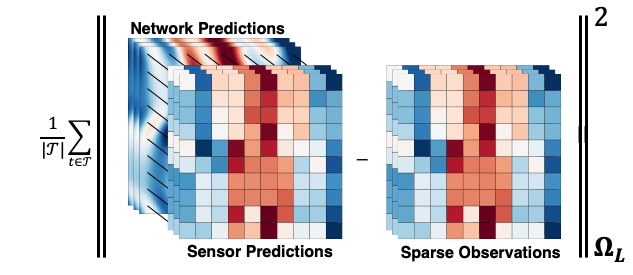
    </center>
</div>

First we obtain the equivalent low-resolution grid from our *high-resolution* network prediction. This is then compared against the input to the network. The loss is averaged over each sample, allowing us to find a mean gradient update in the optimisation procedure.


### **Residual Based Loss - $\mathcal{L}_{\mathcal{R}}$**
Given that we have knowledge of the underlying physics, we can penalise the network if the predictions do not conform to imposed physical laws. In this case, we know the equations describing the Kolmogorov flow and so we can compute the residual of the predictions. In order to do this we will use the `TimeDistributed` layers described above to operate over adjacent time-steps:

<div>
    <center>
        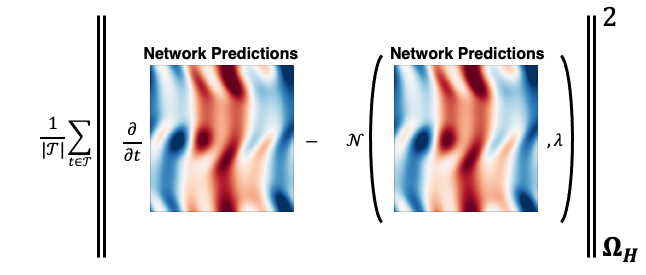
    </center>
</div>

We compute the time-derivative $\partial_t (\;\cdot\;)$ through the Euler forward-difference scheme: $\partial_t u = \frac{1}{\Delta t} (u^{n + 1} - u^n)$. This is made possible by the `TimeDistributed` layer as we know each sample is an adjacent time-step. The differential operator is computed using a solver provided to us by the `kolsol` library. This solver is of the form $s: u \mapsto \partial_t u$. The residual loss is then a function of the difference between these two computations, again averaging over the sample.

### **Total Loss:**
Now we have the two component losses, we simply compute a weighted sum:

$$
\begin{equation}
    \mathcal{L}_T = \mathcal{L}_{\mathcal{O}} + \alpha \mathcal{L}_{\mathcal{R}}
\end{equation}
$$

This will be the objective for our network to minimise via gradient descent and will ensure that we are super resolving appropriately.

In [23]:
class KolmogorovLoss:

    def __init__(self, dt: float, nk: int, nf: int, re: float, device: torch.device) -> None:

        """Kolmogorov Loss Class.
        
        Parameters
        ----------
        dt: float
            Length of the time-step
        """

        self.dt = dt
        self.solver = KolSol(nk=nk, nf=4, re=re, ndim=2, device=device)

    def calc_residual_loss(self, u: torch.Tensor) -> torch.Tensor:

        """Calculate the L2 norm of a field, u, in the Fourier domain.
        
        Parameters
        ----------
        u: torch.Tensor
            Field in the physical domain.
        
        Returns
        -------
        loss: torch.Tensor
            L2 norm of the field, calculated in the Fourier domain.
        """

        u = einops.rearrange(u, 'b t u i j -> b t i j u')
        u_hat = self.solver.phys_to_fourier(u)

        # analytical derivative
        a_dudt_hat = self.solver.dynamics(u_hat)
        
        # we lose the final sample as we operate on pairs when doing the Euler forward difference below.
        a_dudt_hat = a_dudt_hat[:, :-1, ...]        

        # empirical derivative - Euler forward difference
        e_dudt_hat = (1.0 / self.dt) * (u_hat[:, 1:, ...] - u_hat[:, :-1, ...])

        res_u = a_dudt_hat - e_dudt_hat
        
        loss = torch.sum(res_u * torch.conj(res_u)) / res_u.numel()

        return loss

In [24]:
loss_fn = KolmogorovLoss(nk=NK, nf=4, re=RE, dt=DT, device=DEVICE)

In [25]:
cuda_validation_u = validation_u.to(DEVICE)
residual_loss = loss_fn.calc_residual_loss(cuda_validation_u).item()

print(f'Residual loss computed on actual data = {abs(residual_loss):.5E}')

# do not clutter gpu
del cuda_validation_u
del residual_loss

Residual loss computed on actual data = 2.38260E-06


## **05 :: Defining the Training Loop:**

Now we have all of the components we will define the training loop:

<div>
    <center>
        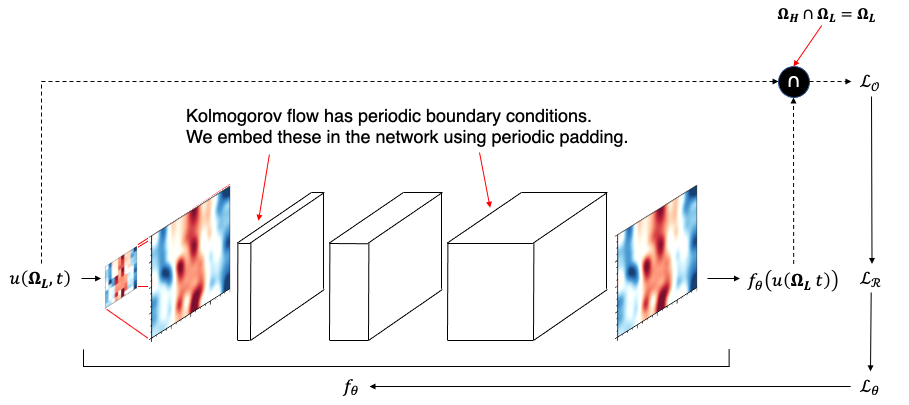
    </center>
</div>

For each sample in the dataloader we will compute a prediction of the corresponding high-resolution field. We will then compute the loss before backpropagating and updating the weights. We will also compute a relative $\ell^2$-error between the predicted field and the true, high-resolution field. **Note:** this will not be used in the training process and it merely a metric we can use to determine how well the model is performing on the actual task.

In [26]:
def train_loop(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: KolmogorovLoss,
               optimizer: Optional[torch.optim.Optimizer] = None,
               lambda_weight: float = 1e-6,
               sr_factor: int = 7,
               set_train: bool = False) -> dict[str, float]:

    """Run a single training / evaluation loop.
    
    Parameters
    ----------
    model: nn.Module
        Model to use for evaluation.
    dataloader: DataLoader
        Generator to retrieve data for evaluation from.
    loss_fn: KolmogorovLoss
        Loss function for calculating physics-informed aspect of the loss.
    optimizer: Optional[torch.optim.Optimizer]
        Optimiser used to update the weights of the model, when applicable.
    lambda_weight: float
        Weighting factor for the momentum loss.
    sr_factor: int
        Super-Resolution factor.
    set_train: bool
        Determine whether run in training / evaluation mode.
    
    Returns
    -------
    LossTracker
        Loss tracking object to hold information about the training progress.
    """

    # data-driven loss
    batched_sensor_loss = (0.0 + 0.0j)
    batched_l2_sensor_loss = (0.0 + 0.0j)

    # physics-based loss
    batched_momentum_loss = (0.0 + 0.0j)
    
    # total loss
    batched_total_loss = (0.0 + 0.0j)

    # l2 loss against actual data
    batched_l2_actual_loss = (0.0 + 0.0j)

    model.train(mode=set_train)
    for hi_res in dataloader:
        
        hi_res = hi_res.to(DEVICE, non_blocking=True)
        lo_res = get_low_res_grid(hi_res, factor=sr_factor)

        # predict the high-resolution field
        pred_hi_res = model(lo_res)
        
        #### COMPUTE LOSSES ##########################################################################################

        # LOSS :: 01 :: Sensor Locations
        pred_sensor_measurements = get_low_res_grid(pred_hi_res, factor=sr_factor)
        
        ## sensor_loss for computing the total loss
        mag_sensor_err = torch.sum((pred_sensor_measurements - lo_res) ** 2)
        sensor_loss = mag_sensor_err / lo_res.numel()

        ## compute relative l2-error at sensor locations
        l2_sensor_loss = torch.sqrt(mag_sensor_err / torch.sum(lo_res ** 2))

        # LOSS :: 02 :: Momentum Loss
        momentum_loss = loss_fn.calc_residual_loss(pred_hi_res)

        # LOSS :: 03 :: Total Loss -- This is used for backpropogation
        total_loss = sensor_loss + lambda_weight * momentum_loss
        
        # LOSS :: 04 :: Actual Loss - relative l2-error between predicted and actual
        l2_actual_loss = torch.sqrt(torch.sum((hi_res - pred_hi_res) ** 2) / torch.sum(hi_res ** 2))

        #### UPDATE BATCH LOSSES #####################################################################################
        batched_sensor_loss += sensor_loss.item() * hi_res.size(0)
        batched_l2_sensor_loss += l2_sensor_loss.item() * hi_res.size(0)

        batched_momentum_loss += momentum_loss.item() * hi_res.size(0)

        batched_total_loss += total_loss.item() * hi_res.size(0)

        batched_l2_actual_loss += l2_actual_loss.item() * hi_res.size(0)

        #### UPDATE GRADIENTS ########################################################################################
        if set_train and optimizer:

            optimizer.zero_grad(set_to_none=True)

            total_loss.backward()
            optimizer.step()

    #### NORMALISE BATCH LOSSES #######################################################################################
    batched_sensor_loss = float(abs(batched_sensor_loss)) / len(dataloader.dataset)
    batched_l2_sensor_loss = float(abs(batched_l2_sensor_loss)) / len(dataloader.dataset)
    
    batched_momentum_loss = float(abs(batched_momentum_loss)) / len(dataloader.dataset)
    
    batched_total_loss = float(abs(batched_total_loss)) / len(dataloader.dataset)
    
    batched_l2_actual_loss = float(abs(batched_l2_actual_loss)) / len(dataloader.dataset)

    loss_dict: dict[str, float] = {
        'sensor_loss': batched_sensor_loss,
        'l2_sensor_loss': batched_l2_sensor_loss,
        'momentum_loss': batched_momentum_loss,
        'total_loss': batched_total_loss,
        'l2_actual_loss': batched_l2_actual_loss
    }

    return loss_dict

## **06 :: Training the Model:**

Recall that we wish to solve the optimisation problem: 


$$
\begin{equation}
\begin{aligned}
\theta^* &= \text{argmin}_\theta \mathcal{L}_T \\
\mathcal{L}_T &= \mathcal{L}_{\mathcal{O}} + \alpha \mathcal{L}_{\mathcal{R}}
\end{aligned}
\end{equation}
$$

Now that we have a function for computing a single update step, all that we have left to do is run this for `N` epochs. We will first load in pre-trained model weights to achieve good super-resolution results in a reasonable time-frame. We will update the model weights for a few epochs to better understand how the training is completed.

**Load existing weights from file**

In [27]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

<All keys matched successfully>

##### **Create Optimizer:**

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2)

**Training Loop:**

In [29]:
_loop_params = dict(model=model, loss_fn=loss_fn, sr_factor=SR_FACTOR, lambda_weight=LAMBDA_WEIGHT)

train_fn = ft.partial(train_loop, **_loop_params, dataloader=train_loader, optimizer=optimizer, set_train=True)
validation_fn = ft.partial(train_loop, **_loop_params, dataloader=validation_loader, set_train=False)

In [30]:
# main training loop
min_validation_loss = np.Inf
for epoch in range(N_EPOCHS):

    lt_training = train_fn()
    lt_validation = validation_fn()

    # update global validation loss if model improves
    if lt_validation['total_loss'] < min_validation_loss:
        min_validation_loss = lt_validation['total_loss']

    # print update to stdout
    msg = f'Epoch: {epoch:05}'
    for k in ('l2_actual_loss', 'l2_sensor_loss','total_loss'):
        msg += f' | t_{k}: {lt_training[k]:08.5e}'

    print(msg)

Epoch: 00000 | t_l2_actual_loss: 1.14917e-01 | t_l2_sensor_loss: 8.24526e-02 | t_total_loss: 6.79285e-03
Epoch: 00001 | t_l2_actual_loss: 8.64583e-02 | t_l2_sensor_loss: 4.02444e-02 | t_total_loss: 1.43588e-03
Epoch: 00002 | t_l2_actual_loss: 7.84326e-02 | t_l2_sensor_loss: 2.20379e-02 | t_total_loss: 5.21344e-04
Epoch: 00003 | t_l2_actual_loss: 7.67172e-02 | t_l2_sensor_loss: 1.56260e-02 | t_total_loss: 3.24357e-04
Epoch: 00004 | t_l2_actual_loss: 7.52982e-02 | t_l2_sensor_loss: 1.25600e-02 | t_total_loss: 2.52433e-04


**Let's see the trained model in action:**

In [31]:
# get sensor observations and move to gpu
sensor_observations = get_low_res_grid(validation_u)
sensor_observations = sensor_observations.to(DEVICE)

# pass sensor observations to the model
hi_res_predictions = model(sensor_observations)

# move back to cpu
sensor_observations = sensor_observations.detach().cpu()
hi_res_predictions = hi_res_predictions.detach().cpu()

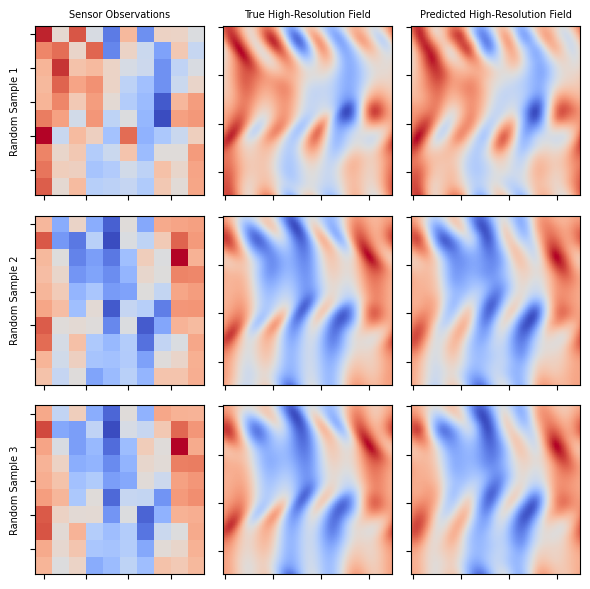

In [32]:
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
axs = axs.flatten()

cmap = 'coolwarm'
fs = 7
random_idx = np.random.choice(np.arange(sensor_observations.shape[0]), size=3, replace=False)

for i, idx in enumerate(random_idx):
    axs[i * 3 + 0].imshow(sensor_observations[idx, 0, 0, ...], cmap=cmap)
    axs[i * 3 + 1].imshow(validation_u[idx, 0, 0, ...], cmap=cmap)
    axs[i * 3 + 2].imshow(hi_res_predictions[idx, 0, 0, ...], cmap=cmap)
    
    axs[i * 3 + 0].set_ylabel(f'Random Sample {i + 1}', fontsize=fs)
    
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
axs[0].set_title('Sensor Observations', fontsize=fs)
axs[1].set_title('True High-Resolution Field', fontsize=fs)
axs[2].set_title('Predicted High-Resolution Field', fontsize=fs)
    
fig.tight_layout()

In [33]:
# do not clutter gpu
del sensor_observations
del hi_res_predictions

## **07 :: Postprocessing:**

Now we have a trained model we are ready to postprocess results and see how well we are able to complete the super-resolution task. We will compare the results with classic upsampling techniques: bi-linear and bi-cubic interpolation. Finally, we will inspect the energy spectrum of each of the results and see if we are able to recover smaller scales of turbulence.

In [34]:
class eUpsampling(enum.Enum):
    NEAREST = 'nearest'
    BILINEAR = 'bilinear'
    BICUBIC = 'bicubic'
    

class UpsampledResults(NamedTuple):

    hi_true: torch.Tensor | np.ndarray
    lo_true: torch.Tensor | np.ndarray

    hi_nearest: torch.Tensor | np.ndarray
    hi_bilinear: torch.Tensor | np.ndarray
    hi_bicubic: torch.Tensor | np.ndarray

    hi_predicted: torch.Tensor | np.ndarray

**`get_upsampled()`** -- function responsible for obtaining upsampled predictions for each of the upsampling methods

In [35]:
def get_upsampled(model: nn.Module, hi_res: torch.Tensor, factor: int, batch_size: int) -> UpsampledResults:

    """Upsample the generated low-resolution field.
    
    Parameters:
    -----------
    model: nn.Module
        Model to use for predicted high-resolution field.
    hi_res: torch.Tensor
        Original data - this is then downsampled in the function.
    factor: int
        Upsampling factor to use.
    batch_size: int
        Batch size to use when predicting with the model.
    
    Returns:
    --------
    results: UpsampledResults
        Super-resolved fields for each of the methods.
    """

    def upsample_factory(shape: tuple[int, int], upsample: eUpsampling) -> nn.Module:
        return TimeDistributedUpsample(shape, mode=upsample.value)

    lo_res = get_low_res_grid(hi_res, factor=factor)

    shape = (hi_res.shape[-1], hi_res.shape[-1])
    hi_nearest = upsample_factory(shape, eUpsampling.NEAREST)(lo_res)
    hi_bilinear = upsample_factory(shape, eUpsampling.BILINEAR)(lo_res)
    hi_bicubic = upsample_factory(shape, eUpsampling.BICUBIC)(lo_res)

    _dataloader_kwargs = dict(shuffle=False, drop_last=False, batch_size=batch_size)
    dataloader = generate_dataloader(hi_res, DEVICE_KWARGS, _dataloader_kwargs)

    hi_predicted = torch.zeros_like(hi_res)
    for idx, batched_hi_res in enumerate(dataloader):
        batched_lo_res = get_low_res_grid(batched_hi_res, factor=factor).to(DEVICE)
        hi_predicted[idx * batch_size : idx * batch_size + batched_hi_res.size(0), ...] = model(batched_lo_res).detach().cpu()

    results = UpsampledResults(
        hi_true=hi_res,
        lo_true=lo_res,
        hi_nearest=hi_nearest,
        hi_bilinear=hi_bilinear,
        hi_bicubic=hi_bicubic,
        hi_predicted=hi_predicted
    )

    return results

In [36]:
upsampled_fields = get_upsampled(model, validation_u, factor=SR_FACTOR, batch_size=BATCH_SIZE)

**`get_energy_spectrum()`** -- function to obtain the turbulent kinetic energy spectrum for each of the upsampled results

In [37]:
def get_energy_spectrum(upsampled_results: UpsampledResults, loss_fn: KolmogorovLoss) -> UpsampledResults:

    """Compute the energy spectrum.
    
    Parameters:
    -----------
    upsampled_results: UpsampledResults
        Upsampled fields to compute energy spectrum for.
    loss_fn: KolmogorovLoss
        Loss function which contains solver used to compute spectrum.
 
    Returns:
    --------
    es_results: UpsampledResults
        Energy spectrums for each of the upsampled results.
    """

    def to_fourier(arr: torch.Tensor) -> torch.Tensor:
        return loss_fn.solver.phys_to_fourier(einops.rearrange(arr[:, 0, ...], 'b u i j -> b i j u'))

    _results = {}
    for k, v in upsampled_results._asdict().items():

        if k == 'lo_true':
            _results[k] = None
            continue

        _results[k] = loss_fn.solver.energy_spectrum(to_fourier(v), agg=True).detach().cpu().numpy()

    es_results = UpsampledResults(**_results)

    return es_results

In [38]:
energy_spectrums = get_energy_spectrum(upsampled_fields, loss_fn)

In [39]:
def generate_plot(upsampled_fields: UpsampledResults, energy_spectrums: UpsampledResults) -> None:

    """Generates the plot.
    
    Note: this is somewhat hardcoded, for best results please use experimental setting described in the paper.
    
    Parameters:
    -----------
    upsampled_fields: UpsampledResults
        Super-resolved fields for each of the methods.
    energy_spectrums: UpsampledResults
        Energy spectrums for each of the super-resolved fields.
    """

    # convert all fields to numpy array
    _res = {}
    for k, v in upsampled_fields._asdict().items():
        _res[k] = v.detach().cpu().numpy()

    upsampled_fields = UpsampledResults(**_res)

    # create figure
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), facecolor='white')
    axs = axs.flatten()

    NX_HR = int(upsampled_fields.hi_true.shape[-1])
    NX_LR = int(upsampled_fields.lo_true.shape[-1])

    cmap = 'RdBu_r'

    title_fontsize = 12
    fontsize = 8
    tick_fontsize = 8
    legend_fontsize = 8

    vmin, vmax = -1.2, 1.2

    random_idx = np.random.choice(np.arange(upsampled_fields.hi_true.shape[0]), 1, replace=False)[0]

    ## plotting the fields #########################################################################################
    im_lo = axs[0].imshow(upsampled_fields.lo_true[random_idx, 0, 0, ...], cmap=cmap, vmin=vmin, vmax=vmax)
    im_hi = axs[3].imshow(upsampled_fields.hi_true[random_idx, 0, 0, ...], cmap=cmap, vmin=vmin, vmax=vmax)

    im_bl = axs[1].imshow(upsampled_fields.hi_bilinear[random_idx, 0, 0, ...], cmap=cmap, vmin=vmin, vmax=vmax)
    im_bc = axs[2].imshow(upsampled_fields.hi_bicubic[random_idx, 0, 0, ...], cmap=cmap, vmin=vmin, vmax=vmax)

    im_pred = axs[4].imshow(upsampled_fields.hi_predicted[random_idx, 0, 0, ...], cmap=cmap, vmin=vmin, vmax=vmax)

    ## plotting the energy spectrum ################################################################################
    x_vals = np.arange(energy_spectrums.hi_true.shape[0])
    ccolors = plt.get_cmap('tab10')(np.arange(5, dtype=int))

    plot_kwargs = dict(lw=0.8)

    ls = (0, (1, 1))

    # nyquist cut-offs for experiment
    nq_lo = 7
    nq_k = 42

    nq_lo_dealiased = round(2/3 * nq_lo)
    nq_k_dealiased = round(2/3 * nq_k)

    axs[5].vlines(nq_lo, 10 ** -15, 10 ** 5, color='k', linestyle='--', linewidth=0.5, alpha=1.0, label=r'Nyquist $f_{\Omega}^{n}$')
    axs[5].vlines(nq_k, 10 ** -15, 10 ** 5, color='k', linestyle='--', linewidth=0.5, alpha=1.0)

    axs[5].vlines(nq_lo_dealiased, 10 ** -15, 10 ** 5, color='k', linestyle=':', linewidth=0.5, alpha=1.0, label=r'$\frac{2}{3}f_{\Omega}^{n}$')
    axs[5].vlines(nq_k_dealiased, 10 ** -15, 10 ** 5, color='k', linestyle=':', linewidth=0.5, alpha=1.0)

    # high-resolution
    axs[5].plot(x_vals[:(nq_k_dealiased + 1)], energy_spectrums.hi_true[:(nq_k_dealiased + 1)], label=r'$u(\Omega_{H}, t)$', color=ccolors[0], **plot_kwargs)
    axs[5].plot(x_vals[nq_k_dealiased:], energy_spectrums.hi_true[nq_k_dealiased:], color=ccolors[0], linestyle=ls, **plot_kwargs)

    # low-resolution
    axs[5].plot(x_vals[:(nq_lo_dealiased + 1)], energy_spectrums.hi_nearest[:(nq_lo_dealiased + 1)], label=r'$u(\Omega_{L}, t)$', color=ccolors[1], **plot_kwargs)
    axs[5].plot(x_vals[nq_lo_dealiased:-1], energy_spectrums.hi_nearest[nq_lo_dealiased:-1], color=ccolors[1], linestyle=ls, **plot_kwargs)

    # bi-cubic upsampling
    axs[5].plot(x_vals[:(nq_k_dealiased + 1)], energy_spectrums.hi_bicubic[:(nq_k_dealiased + 1)], label=r'$BC(u(\Omega_{L}, t))$', color=ccolors[2], **plot_kwargs)
    axs[5].plot(x_vals[nq_k:], energy_spectrums.hi_bicubic[nq_k:], color=ccolors[2], linestyle=ls, **plot_kwargs)

    # bi-linear upsampling
    axs[5].plot(x_vals[:(nq_k_dealiased + 1)], energy_spectrums.hi_bilinear[:(nq_k_dealiased + 1)], label=r'$BL(u(\Omega_{L}, t))$', color=ccolors[3], **plot_kwargs)
    axs[5].plot(x_vals[nq_k_dealiased:], energy_spectrums.hi_bilinear[nq_k_dealiased:], color=ccolors[3], linestyle=ls, **plot_kwargs)

    # PREDICTED
    axs[5].plot(x_vals[:(nq_k_dealiased + 1)], energy_spectrums.hi_predicted[:(nq_k_dealiased + 1)], label=r'$f_{\theta}(u(\Omega_{L}, t))$', color=ccolors[4], **plot_kwargs)
    axs[5].plot(x_vals[nq_k_dealiased:], energy_spectrums.hi_predicted[nq_k_dealiased:], color=ccolors[4], linestyle=ls, **plot_kwargs)

    ## setting the axis parameters #################################################################################
    for ax in axs:
        ax.set_box_aspect(1)

    tick_loc_lo = np.linspace(-0.5, NX_LR - 0.5, 4 + 1)
    tick_loc_hi = np.linspace(-0.5, NX_HR - 0.5, 4 + 1)

    # axes for low-resolution image
    for axis in [axs[0].xaxis, axs[0].yaxis]:
        axis.set_ticks(tick_loc_lo)
        axis.set_minor_locator(tck.AutoMinorLocator())
        axis.set_major_formatter(tck.NullFormatter())

    axs[0].set_xlim(-0.5, NX_LR - 0.5)
    axs[0].set_ylim(-0.5, NX_LR - 0.5)

    # axes for high-resolution images
    for i in range(1, 5):

        for axis in [axs[i].xaxis, axs[i].yaxis]:
            axis.set_ticks(tick_loc_hi)
            axis.set_minor_locator(tck.AutoMinorLocator())
            axis.set_major_formatter(tck.NullFormatter())

        axs[i].set_xlim(-0.5, NX_HR - 0.5)
        axs[i].set_ylim(-0.5, NX_HR - 0.5)


    axs[5].tick_params(which='both', labelsize=tick_fontsize)

    # setting titles
    title_pad = 5
    axs[0].set_title(r'$u(\Omega_{L}, t)$', fontsize=title_fontsize, pad=title_pad)
    axs[3].set_title(r'$u(\Omega_{H}, t)$', fontsize=title_fontsize, pad=title_pad)

    axs[1].set_title(r'$BL(u(\Omega_{L}, t))$', fontsize=title_fontsize, pad=title_pad)
    axs[2].set_title(r'$BC(u(\Omega_{L}, t))$', fontsize=title_fontsize, pad=title_pad)
    axs[4].set_title(r'$f_{\theta}(u(\Omega_{L}, t))$', fontsize=title_fontsize, pad=title_pad)

    axs[5].set_title(r'Energy Spectrum', fontsize=title_fontsize, pad=title_pad)
    leg = axs[5].legend(fontsize=legend_fontsize, facecolor='white', framealpha=1, edgecolor='k')
    leg.get_frame().set_linewidth(0.1)
    leg.get_frame().set_boxstyle('square', pad=0.1)

    # adding text and scaling energy spectrum plot
    axs[5].set_xscale('log')
    axs[5].set_yscale('log')

    axs[5].text(7.3, 10 ** 3.7, r'$f_{\Omega_{L}}^{n}$', fontsize=5)
    axs[5].text(43.1, 10 ** 3.7, r'$f_{\hat{\Omega}_{k}}^{n}$', fontsize=5)

    axs[5].set_yticks([10 ** i for i in range(-15, 5)])
    axs[5].yaxis.set_major_formatter(tck.NullFormatter())

    ytick_labels = [r'$10^{-15}$'] + 18 * [''] + [r'$10^{4}$']
    axs[5].set_yticklabels(ytick_labels, fontsize=tick_fontsize)

    axs[5].set_xlabel(r'$|k|$', fontsize=fontsize, labelpad=3)
    axs[5].set_ylabel(r'$E(|k|)$', fontsize=fontsize, labelpad=-12)

    axs[5].yaxis.tick_right()
    axs[5].yaxis.set_label_position('right')

    axs[5].set_xlim(10 ** 0, 10 ** 2)
    axs[5].set_ylim(10 ** -15, 10 ** 5)

    axs[5].grid(which='both', alpha=0.05, color='k')

    ## adding the colourbar ########################################################################################
    divider = make_axes_locatable(axs[2])
    cax = divider.append_axes('right', size='5%', pad=0.03)
    cb = fig.colorbar(im_bc, cax=cax)

    cax.tick_params(labelsize=tick_fontsize)


    ## trick to align last plot ####################################################################################
    divider = make_axes_locatable(axs[5])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = fig.colorbar(im_bc, cax=cax)
    cax.tick_params(labelsize=tick_fontsize)

    cb.remove()


    ## aligning plots and saving ###################################################################################
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=0.3)

    return fig    

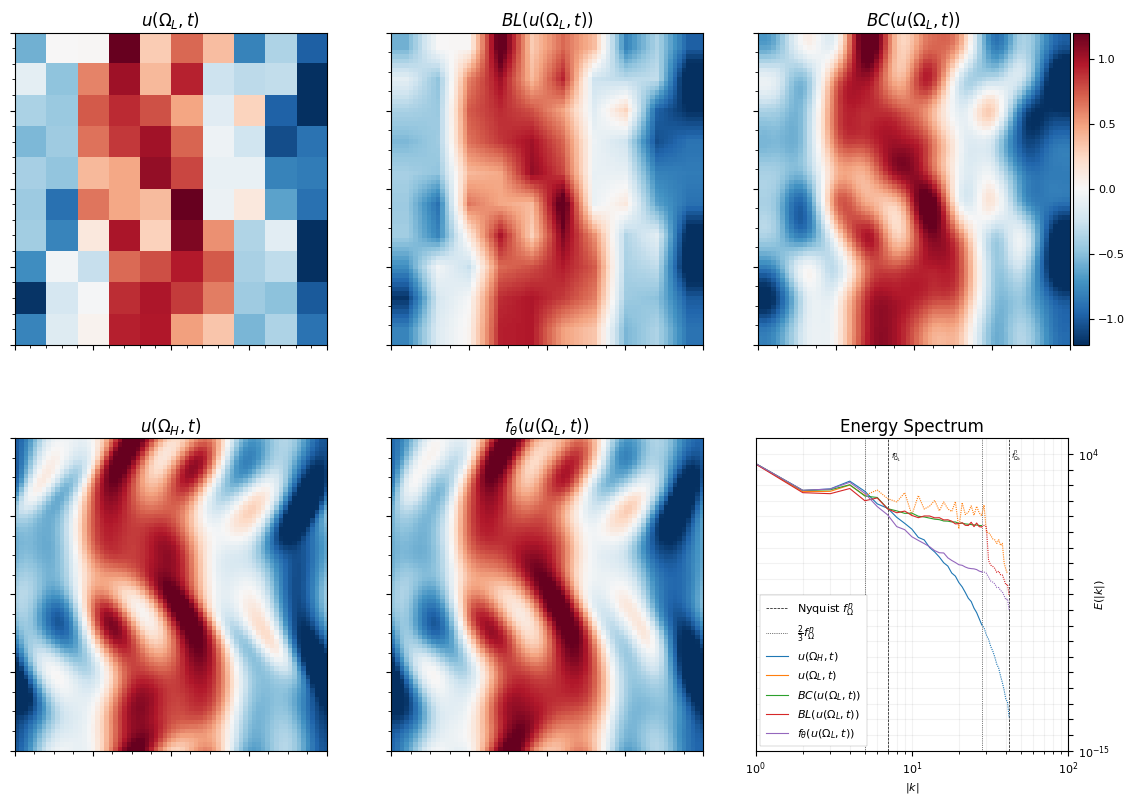

In [40]:
fig = generate_plot(upsampled_fields, energy_spectrums)

## **08 :: Homework:**

There are a number of ways in which the super-resolution task might be improved:

1. For the sake of this workshop we have chosen arbitrary hyperparameters for training the network.
   <br>Can you find a better set of hyperparameters for the network training?
2. Can we operate with a different super-resolution factor?
   <br> You may have to generate your own data using [`kolsol`](https://github.com/magrilab/kolsol) for this.
3. Since we are operating in the Fourier domain, can you think how weighting the wavenumbers differently might help?
4. Throughout this notebook we have embedded information about the periodic boundary conditions into the model. What happens if we remove this?
5. The residual based weighting $\alpha$ is very small -- what happens when we increase this?

You may also be interested in reading our paper on corruptedion removal on dynamical systems [[2]](#References:), many of the same concepts learned above will apply here.

## **References:**

[1] D.Kelshaw, and L. Magri, “Physics-Informed Convolutional Neural Networks for Corruption Removal on Dynamical Systems,” in NeurIPS 2022 Workshop on Machine Learning and the Physical Sciences, 2022.
<br>[2] D.Kelshaw, G. Rigas, and L. Magri, “Physics-Informed CNNs for Super-Resolution of Sparse Observations on Dynamical Systems,” in NeurIPS 2022 Workshop on Machine Learning and the Physical Sciences, 2022.
